### Optimal control of phenomenological models, e.g. the model model
This notebook shows how to compute the optimal control (OC) signal for the model model for a simple example task. For the Hopf-model the OC can be computed completely analogously.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [6]:
# We import the model
model = WCModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 40.
amplitude = 1.
period = duration / 4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
x_init = 0.011225367461896877
y_init = 0.013126741089502588
model.params["exc_init"] = np.array([[x_init]])
model.params["inh_init"] = np.array([[y_init]])

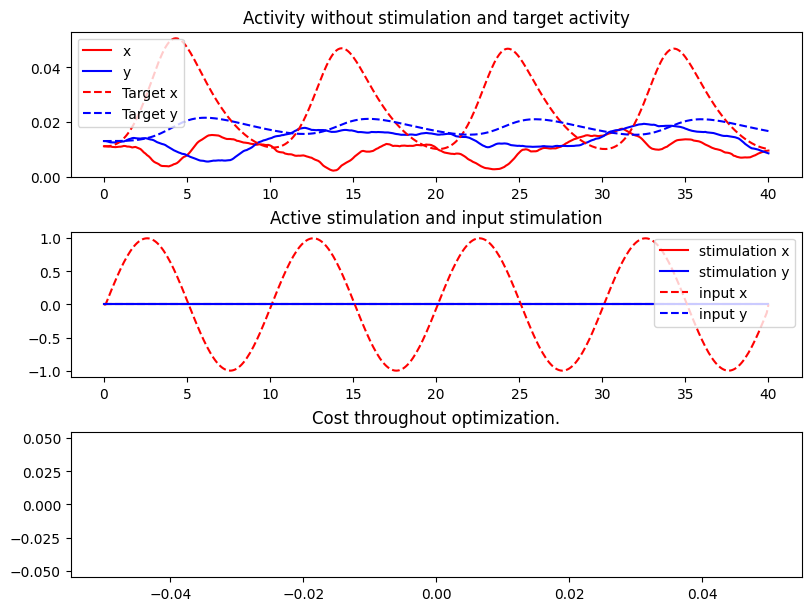

In [7]:
# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
# Change sigma_ou_parameter to adjust the noise strength
model.params['sigma_ou'] = 0.01
model.params['tau_ou'] = 1.
model.params["exc_ext"] = zero_input
model.params["inh_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

The target is a periodic oscillation of x and y variable (computed in deterministic, noise-free system).

The noisy, undistrubed system fluctuates around zero.

For the optimization, you can now set several new parameters:
- M: the number of noise realizations that the algorithm averages over. Default=1
- M_validation: the number of noise realization the final cost is computed from. Default=1000
- validate_per_step: If True, the cost for each step is computed averaging over M_validation instead of M realizations, this takes much longer. Default=False
- method: determines, how the noise averages are computed. Results may vary for different methods depending on the specific task. Choose from ['3']. Default='3'

Please note:
- higher number of iterations does not promise better results for computations in noisy systems. The cost will level off at some iteration number, and start increasing again afterwards. Make sure not to perform too many iterations.
- M, M_validation should increase with sigma_ou model parameter
- validate_per_step does not impact the control result

Let's optimize with the following parameters: M=20, iterations=100

Compute control for a noisy system
Mean cost in iteration 0: 0.008843694810789617
Mean cost in iteration 10: 0.0019027419351081145
Mean cost in iteration 20: 0.001844417767180835
Mean cost in iteration 30: 0.0018778073868611711
Mean cost in iteration 40: 0.0018768549321057791
Mean cost in iteration 50: 0.0018352070510624042
Mean cost in iteration 60: 0.0018251425383908875
Mean cost in iteration 70: 0.0018313508646310335
Mean cost in iteration 80: 0.0018574750107952693
Mean cost in iteration 90: 0.001845686216341713
Mean cost in iteration 100: 0.0018802471751377774
Minimal cost found at iteration 76
Final cost validated with 500 noise realizations : 0.0019068629425081367


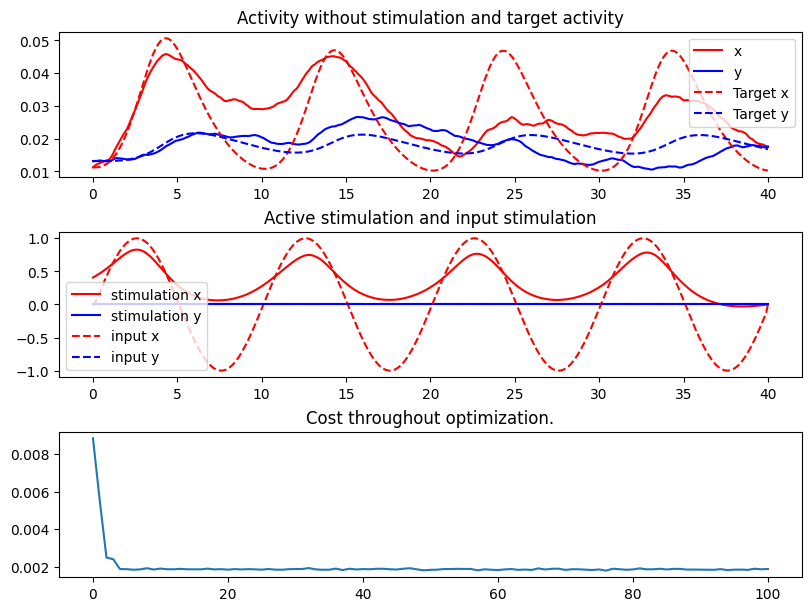

In [8]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model.params["exc_ext"] = zero_input
model.params["inh_ext"] = zero_input
controlmat = np.zeros((1,2))
controlmat[0,0] = 1.
model_controlled = oc_wc.OcWc(model, target, print_array=np.arange(0,101,10), control_matrix = controlmat,
        M=20, M_validation=500, validate_per_step=True)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)


Let's do the same thing with different parameters: M=100, iterations=30

Compute control for a noisy system
Mean cost in iteration 0: 0.008751269858867856
Mean cost in iteration 5: 0.004961209154007158
Mean cost in iteration 10: 0.0016370809639103144
Mean cost in iteration 15: 0.0015511141351442262
Mean cost in iteration 20: 0.001525447722902345
Mean cost in iteration 25: 0.0015500576887386426
Mean cost in iteration 30: 0.0015538558215643084
Minimal cost found at iteration 26
Final cost validated with 500 noise realizations : 0.0015065740477425147


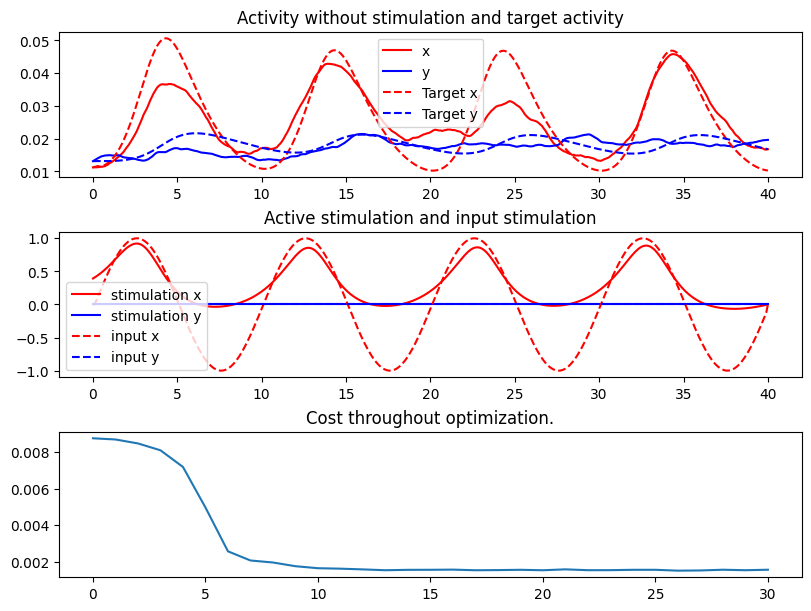

In [9]:
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input

model_controlled = oc_wc.OcWc(model, target, print_array=np.arange(0,31,5), control_matrix = controlmat,
        M=100, M_validation=500, validate_per_step=True)

model_controlled.optimize(30)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

### Network case

Let us know study a simple 2-node network of model oscillators. We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

0.013899838666082324 0.012935433093208744
0.014302112067956984 0.0139290686481899


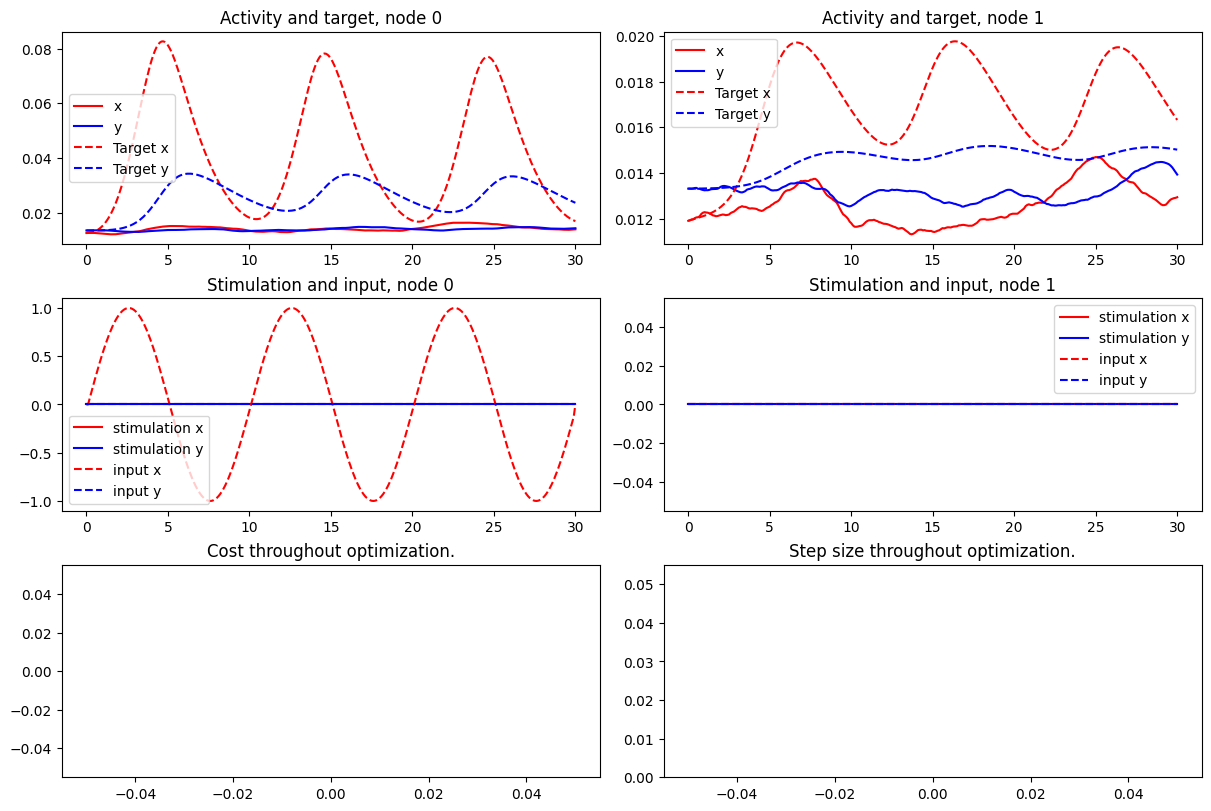

In [10]:
cmat = np.array( [[0., 1.], [0.5, 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.coupling = "additive" # use additive coupling

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in y-channel in node 0

model.params.K_gl = 10.

# noise free target
model.params['sigma_ou'] = 0.

duration = 30.
amplitude = 1.
period = duration / 3.

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well
model.params["exc_init"] = np.vstack( [0.01255381969006173, 0.01190300495001282] )
model.params["inh_init"] = np.vstack( [0.013492631513639169, 0.013312224583806076] )


# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["exc_ext"] = input_nw[:,0,:]
model.params["inh_ext"] = input_nw[:,1,:]

model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params['sigma_ou'] = 0.002
model.params['tau_ou'] = 1.
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model.run()

print(model.exc[0,-1], model.exc[1,-1])
print(model.inh[0,-1], model.inh[1,-1])

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Let's optimize with the following parameters: M=20, iterations=100

Compute control for a noisy system
Mean cost in iteration 0: 0.0003412941970649841
Mean cost in iteration 10: 0.00033681848160854245
Mean cost in iteration 20: 0.000339844454049806
Mean cost in iteration 30: 0.0003377145560502177
Mean cost in iteration 40: 0.0003353663553566474
Mean cost in iteration 50: 0.00033814098623907463
Mean cost in iteration 60: 0.00033575888151948715
Mean cost in iteration 70: 0.00033495753355055154
Mean cost in iteration 80: 0.0003377815310451191
Mean cost in iteration 90: 0.0003277820145309714
Mean cost in iteration 100: 0.0003367115367775724
Minimal cost found at iteration 90
Final cost validated with 500 noise realizations : 0.00034152684849099446


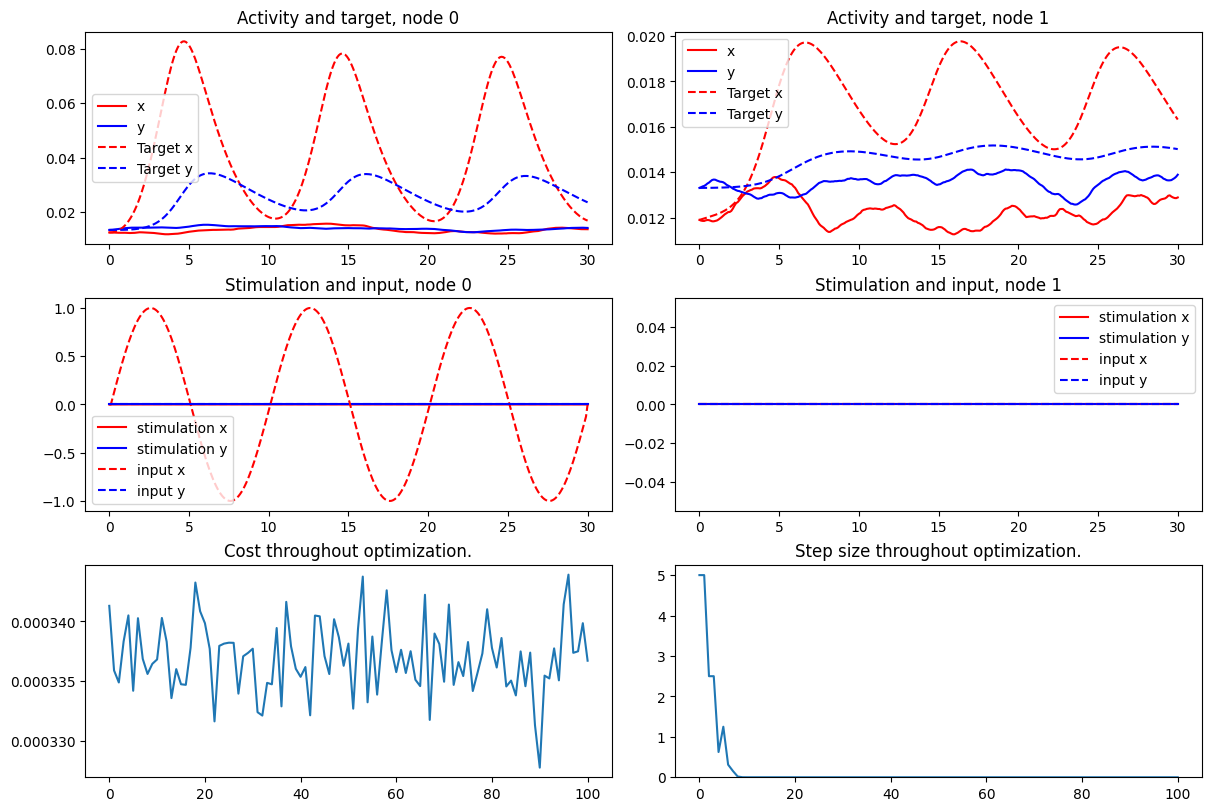

In [11]:
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model_controlled = oc_wc.OcWc(model,
                                target,
                                print_array=np.arange(0,101,10),
                                control_matrix=control_mat,
                                precision_matrix=prec_mat,
                                M=20,
                                M_validation=500,
                                validate_per_step=True)

model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Let's do the same thing with different parameters: M=100, iterations=30

Compute control for a noisy system
Mean cost in iteration 0: 0.0033833003553087556
Mean cost in iteration 5: 0.0025256901741388268
Mean cost in iteration 10: 0.0009218675864382586
Mean cost in iteration 15: 0.0005904365081961509
Mean cost in iteration 20: 0.00048578337510401403
Mean cost in iteration 25: 0.000430816598863307
Mean cost in iteration 30: 0.0003818735363620576
Minimal cost found at iteration 28
Final cost validated with 500 noise realizations : 0.00038453969819187496


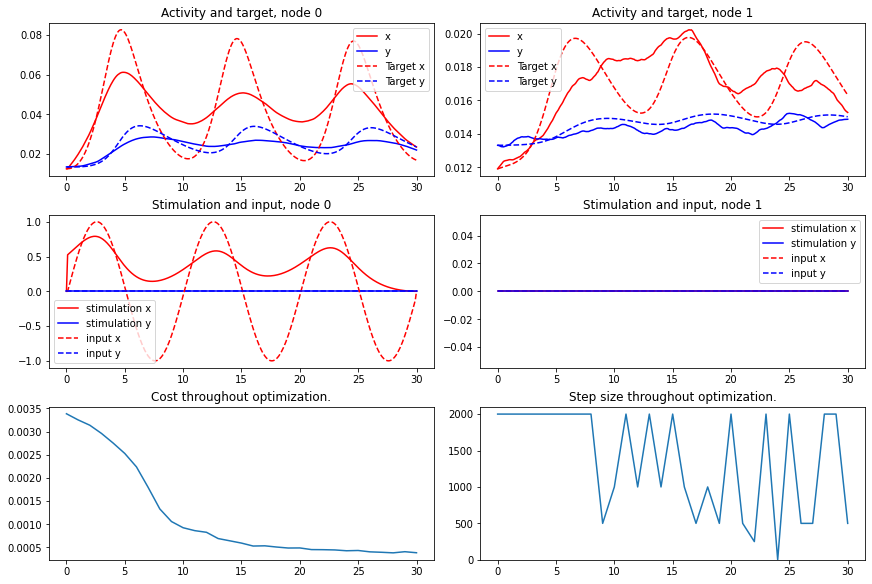

In [ ]:
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model_controlled = oc_wc.OcWc(model,
                                target,
                                print_array=np.arange(0,31,5),
                                control_matrix=control_mat,
                                precision_matrix=prec_mat,
                                M=100,
                                M_validation=500,
                                validate_per_step=True)

model_controlled.optimize(30)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)